In [2]:
import sys 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess

import spycone as spy

# Gene-level workflow

## Prepare the dataset

We use a time series dataset of influenza infection with 9 time points. 

In [ ]:
#sample data
subprocess.call("wget https://zenodo.org/record/7228475/files/normticonerhino_wide.csv?download=1 -O normticonerhino_wide.csv", shell=True)

influ = pd.read_csv("normticonerhino_wide.csv", dtype={'entrezid': str})
gene_list = influ['entrezid'] 
symbs = influ['symbol']

flu_ts = influ.iloc[:,3:] ##filter out the entrez id and gene id column


Import expression data with `DataSet` which stores the count matrix, list of gene ID, number of time points, and number of replicates. \
`ts` : time series data values with columns as each sample e.g. the order of the columns should be **sample1_rep1**, **sample1_rep2**, **sample2_rep1**, **sample2_rep2** and so on.... \
`gene_id` : the pandas series or list of gene id (can be entrez gene id or ensembl gene id) \
`species` : specify the species ID \
`reps1` : Number of replicates \
`timepts` : Number of time points \
`discreization_steps` : Steps to discretize the data values

In [4]:
flu_dset = spy.dataset(ts=flu_ts, 
                        gene_id = gene_list, 
                        symbs=gene_list,
                        species=9606,
                        keytype="entrezgeneid",
                        reps1 = 5, 
                        timepts = 9)

Import biological network of your choice with `BioNetwork`, Spycone provides Biogrid, IID network in entrez ID as node name. Please specify the keytype if you are using a different ID.

In [5]:
bionet = spy.BioNetwork("human", data=(('weight',float),))

## Preprocessing

Filtering out genes that has expression across all time points lower than 1. By giving the biological network, it removes genes from the dataset that are not in the network.

In [6]:
spy.preprocess(flu_dset)

Input data dimension: (5, 19463, 9)
Removed 0 with 0 values.
Filtered data: (5, 19463, 9)


## Clustering

`clustering` create clustering object that provides varies algorithms and result storage.

In [7]:
asclu = spy.clustering(flu_dset, algorithm='hierarchical', metrics="correlation", input_type="expression", n_clusters=10, composite=False)
c = asclu.find_clusters()

clustering took 31.098841428756714s. 


visualizing clustering

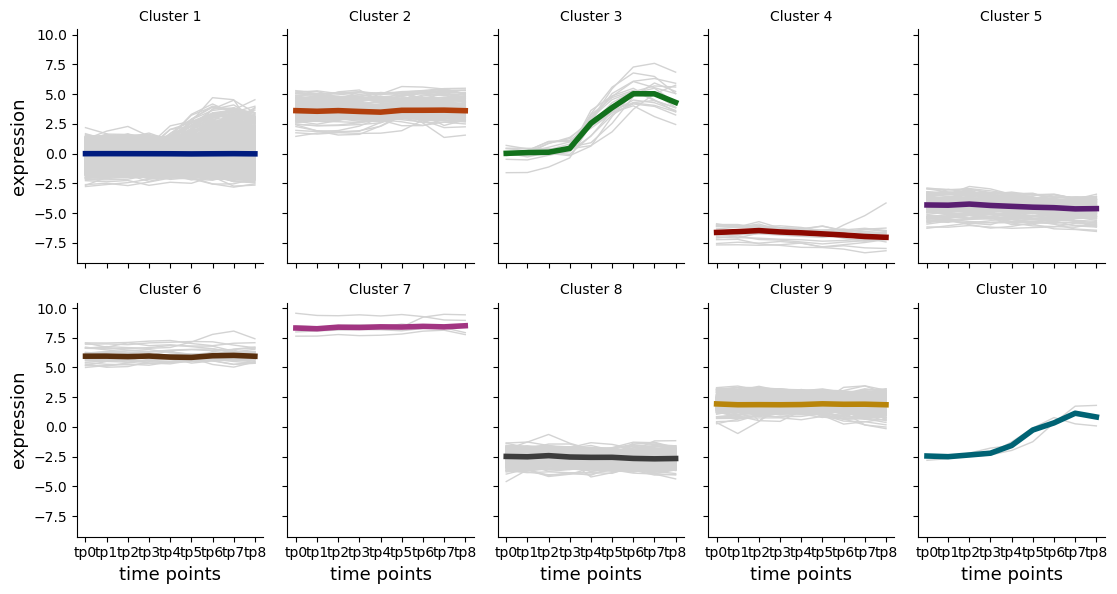

In [8]:
%matplotlib inline
spy.vis_all_clusters(asclu, col_wrap=5)

## Gene set enrichment analysis

Perform gene set enrichment analysis using `clusters_gsea`. Change the gene_sets parameter into the choice of your knowledge base or gene set database, e.g. Reactome, KEGG, etc. Use `spy.list_genesets` to view the available knowledge base.

In [9]:
sys.path.insert(0, "../../../")
from spycone_pkg.spycone.go_terms import clusters_gsea

asclu_go, _ = clusters_gsea(flu_dset, "hsapiens", method="gsea")

In [10]:
from spycone_pkg.spycone.visualize import gsea_plot
gsea_plot(asclu_go, cluster=5, nterms=15)

## Run DOMINO

In [11]:
mods = spy.run_domino(asclu, network_file=bionet, output_file_path="newslices.txt")

To visualize the modules, use `vis_modules`. 

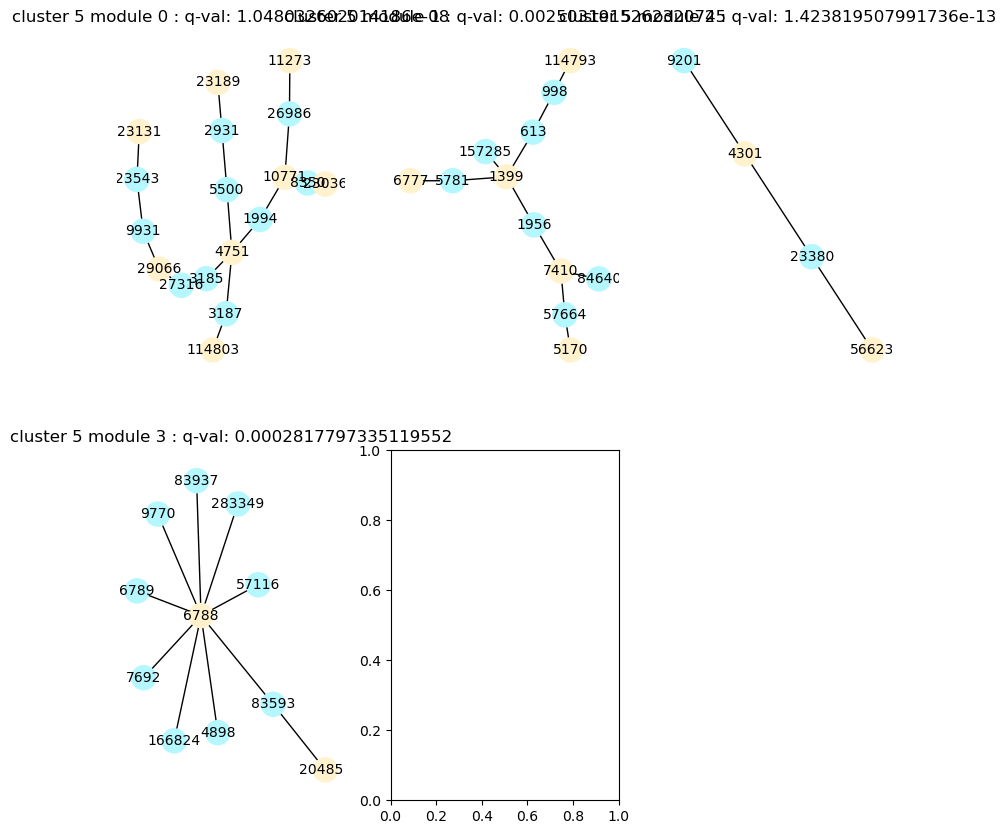

In [12]:
%matplotlib inline
spy.vis_modules(mods, flu_dset, cluster=5, size=0)

It is also possible to visualize modules with javascript, use `vis_better_modules` and input a desired directory, the function will generate networks with dot format (Graphviz) (https://github.com/pydot/pydot).

vis_better_modules(flu_dset, mods, cluster=5, dir='/path/to/file')